# Predicting Exam Scores using Supervised Regression
by Franrey Anthony Saycon

## Problem Statement
Identify which factors have the biggest impact on student exam scores so we can give targeted recommendations to improve performance. 

**Success Criteria**
- R² >= 0.7
- RMSE <= 10

## Data Collection & Understanding

Kaggle Education Dataset: https://www.kaggle.com/datasets/kundanbedmutha/exam-score-prediction-dataset?resource=download

This dataset provides an extensive and realistic representation of various factors that contribute to student exam performance. It contains 20,000 records, each describing a student’s academic behavior, study habits, lifestyle routines, and exam conditions. These variables collectively help understand how different aspects of a student’s daily life and learning environment influence their exam outcomes.

In [168]:
# Import necessary libraries

from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

# for predictable seeding.
RANDOM_STATE = 11

In [169]:
# Load the dataset
df = pd.read_csv('kaggle-exam-score-prediction-dataset.csv')

In [170]:
# Generate Data Dictionary
numeric_dict = []
categorical_dict = []

for col in df.columns:
    dtype = df[col].dtype
    
    # For numeric columns
    if dtype in ['int64', 'float64']:
        info = {
            'Variable': col,
            'Type': str(dtype),
            'Min': df[col].min(),
            'Max': df[col].max(),
            'Mean': round(df[col].mean(), 2),
            'Unique': df[col].nunique()
        }
        numeric_dict.append(info)
    
    # For categorical columns
    else:
        unique_vals = df[col].unique()
        info = {
            'Variable': col,
            'Type': str(dtype),
            'Unique': len(unique_vals),
        }
        categorical_dict.append(info)

In [171]:
numeric_df = pd.DataFrame(numeric_dict)
print("Numeric Data Dictionary:\n")
print(numeric_df.to_string(index=False))

Numeric Data Dictionary:

        Variable    Type    Min      Max     Mean  Unique
      student_id   int64  1.000 20001.00 10000.50   20000
             age   int64 17.000    24.00    20.47       8
     study_hours float64  0.080     7.91     4.01     784
class_attendance float64 40.600    99.40    70.02     589
     sleep_hours float64  4.100     9.90     7.01      59
      exam_score float64 19.599   100.00    62.51     805


In [172]:
categorical_df = pd.DataFrame(categorical_dict)
print("Categorical Data Dictionary:\n")
print(categorical_df.to_string(index=False))

Categorical Data Dictionary:

       Variable   Type  Unique
         gender object       3
         course object       7
internet_access object       2
  sleep_quality object       3
   study_method object       5
facility_rating object       3
exam_difficulty object       3


In [173]:
print("All Categorical Variable Categories:")
for col in categorical_df['Variable']:
    unique_values = df[col].unique()
    print(f"\n{col}:")
    print(f"Categories: {', '.join(map(str, unique_values))}")


All Categorical Variable Categories:

gender:
Categories: male, other, female

course:
Categories: diploma, bca, b.sc, b.tech, bba, ba, b.com

internet_access:
Categories: yes, no

sleep_quality:
Categories: poor, average, good

study_method:
Categories: coaching, online videos, mixed, self-study, group study

facility_rating:
Categories: low, medium, high

exam_difficulty:
Categories: hard, moderate, easy


## EDA + Feature Engineering Report

In [174]:
# Check for null and missing values
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Null Count': df.isnull().sum(),
    'Missing Count': df.isna().sum(),
})
print(missing_summary.to_string(index=False))

          Column  Null Count  Missing Count
      student_id           0              0
             age           0              0
          gender           0              0
          course           0              0
     study_hours           0              0
class_attendance           0              0
 internet_access           0              0
     sleep_hours           0              0
   sleep_quality           0              0
    study_method           0              0
 facility_rating           0              0
 exam_difficulty           0              0
      exam_score           0              0


In [175]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical Columns:", categorical_cols)

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numeric Columns:", numeric_cols)

# Remove student_id from numeric_cols
numeric_cols = [col for col in numeric_cols if col != 'student_id']


Categorical Columns: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
Numeric Columns: ['student_id', 'age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']


In [176]:
print("Outlier detection")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_pct = (len(outliers) / len(df)) * 100
    print(f"  {col}: {len(outliers)} outliers ({outlier_pct:.2f}%)")

print("\nNo outliers were found.")

Outlier detection
  age: 0 outliers (0.00%)
  study_hours: 0 outliers (0.00%)
  class_attendance: 0 outliers (0.00%)
  sleep_hours: 0 outliers (0.00%)
  exam_score: 0 outliers (0.00%)

No outliers were found.


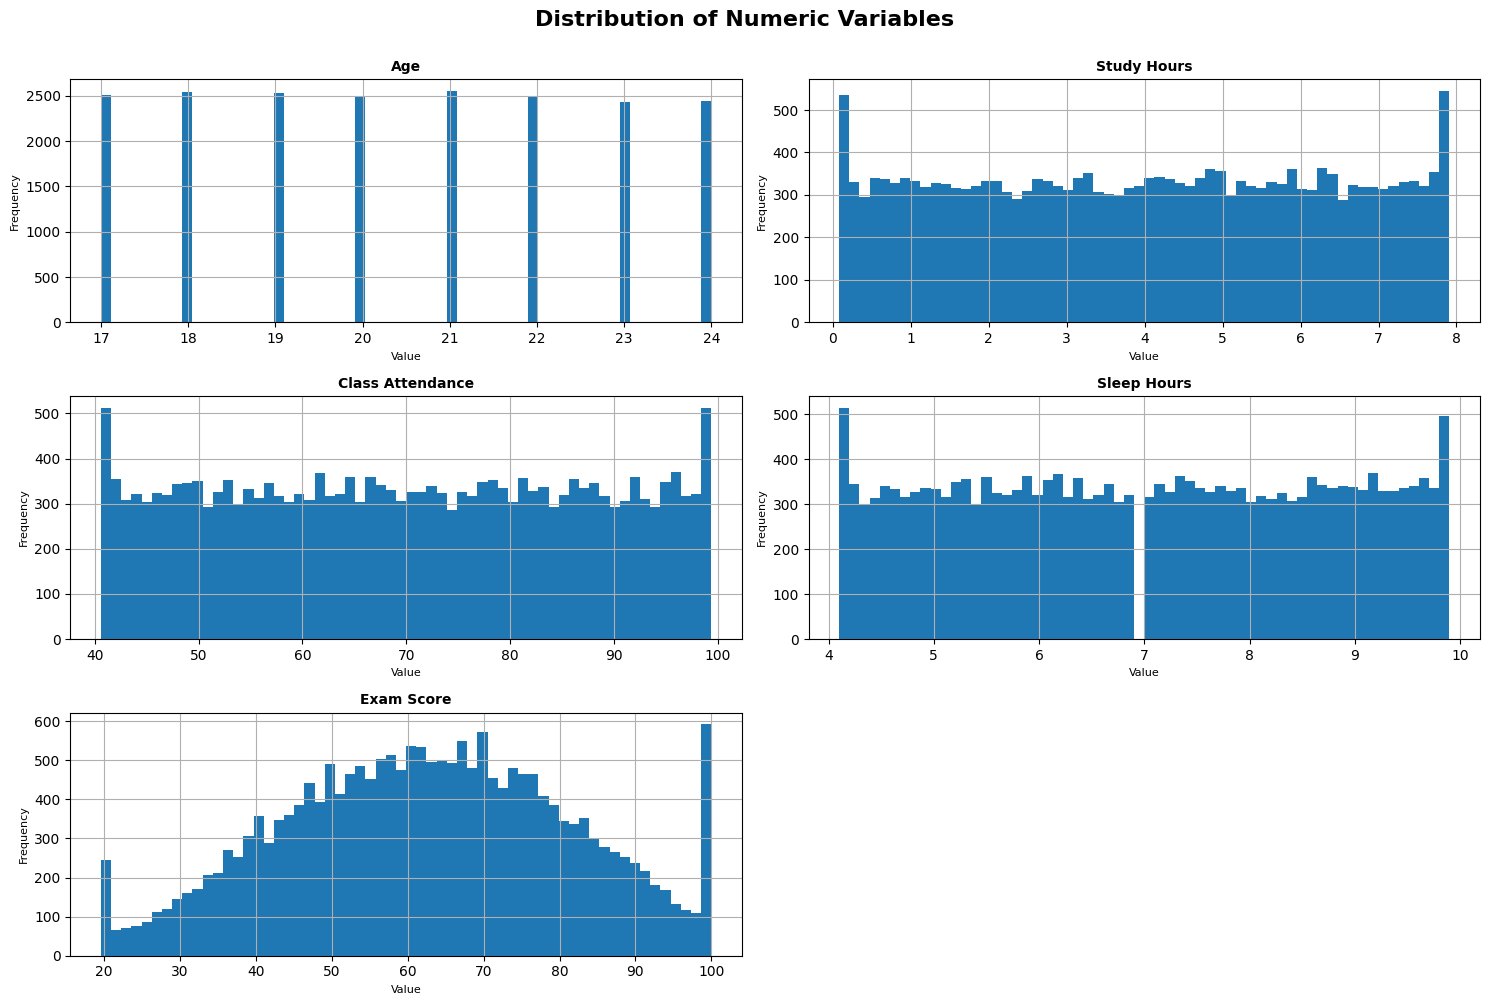

In [177]:
fig = df[numeric_cols].hist(bins=60, figsize=(15,10))

# Add title to each subplot
for i, col in enumerate(numeric_cols):
    ax = fig.flatten()[i]
    ax.set_title(col.replace('_', ' ').title(), fontsize=10, fontweight='bold')
    ax.set_xlabel('Value', fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)

plt.suptitle('Distribution of Numeric Variables', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

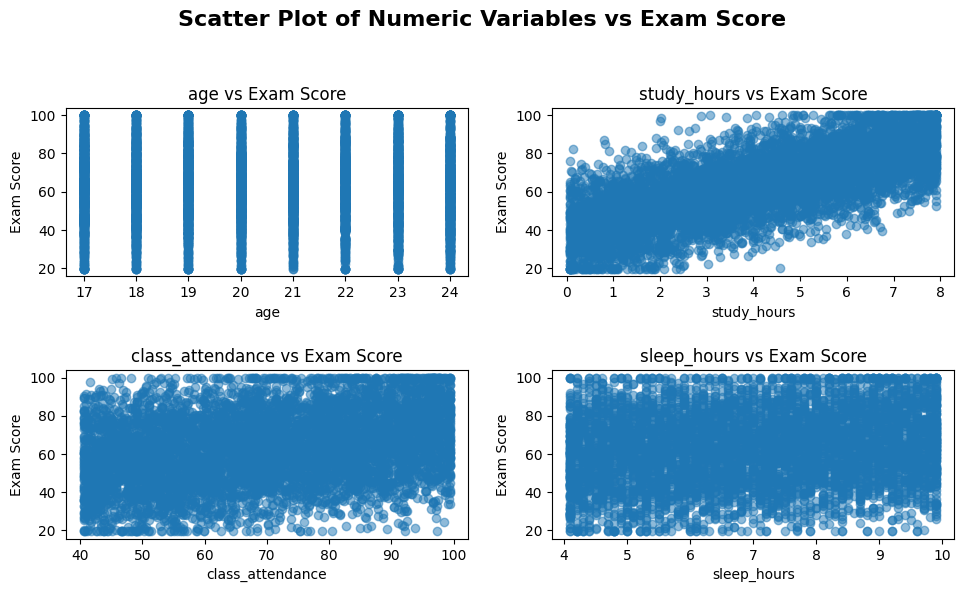

In [178]:
# Sample 30% of data for clearer visualization
df_sample = df.sample(frac=0.3, random_state=RANDOM_STATE)

# Filter out exam_score from the list before creating subplots
cols_to_plot = [col for col in numeric_cols if col != 'exam_score']

# Check all linear relationships with scatter plots between numeric variables and the target variable 'exam_score'
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
axes = axes.flatten() 

for i, col in enumerate(cols_to_plot):
    axes[i].scatter(df_sample[col], df_sample['exam_score'], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Exam Score')
    axes[i].set_title(f'{col} vs Exam Score')

plt.suptitle('Scatter Plot of Numeric Variables vs Exam Score', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout(pad=2.0)
plt.show()

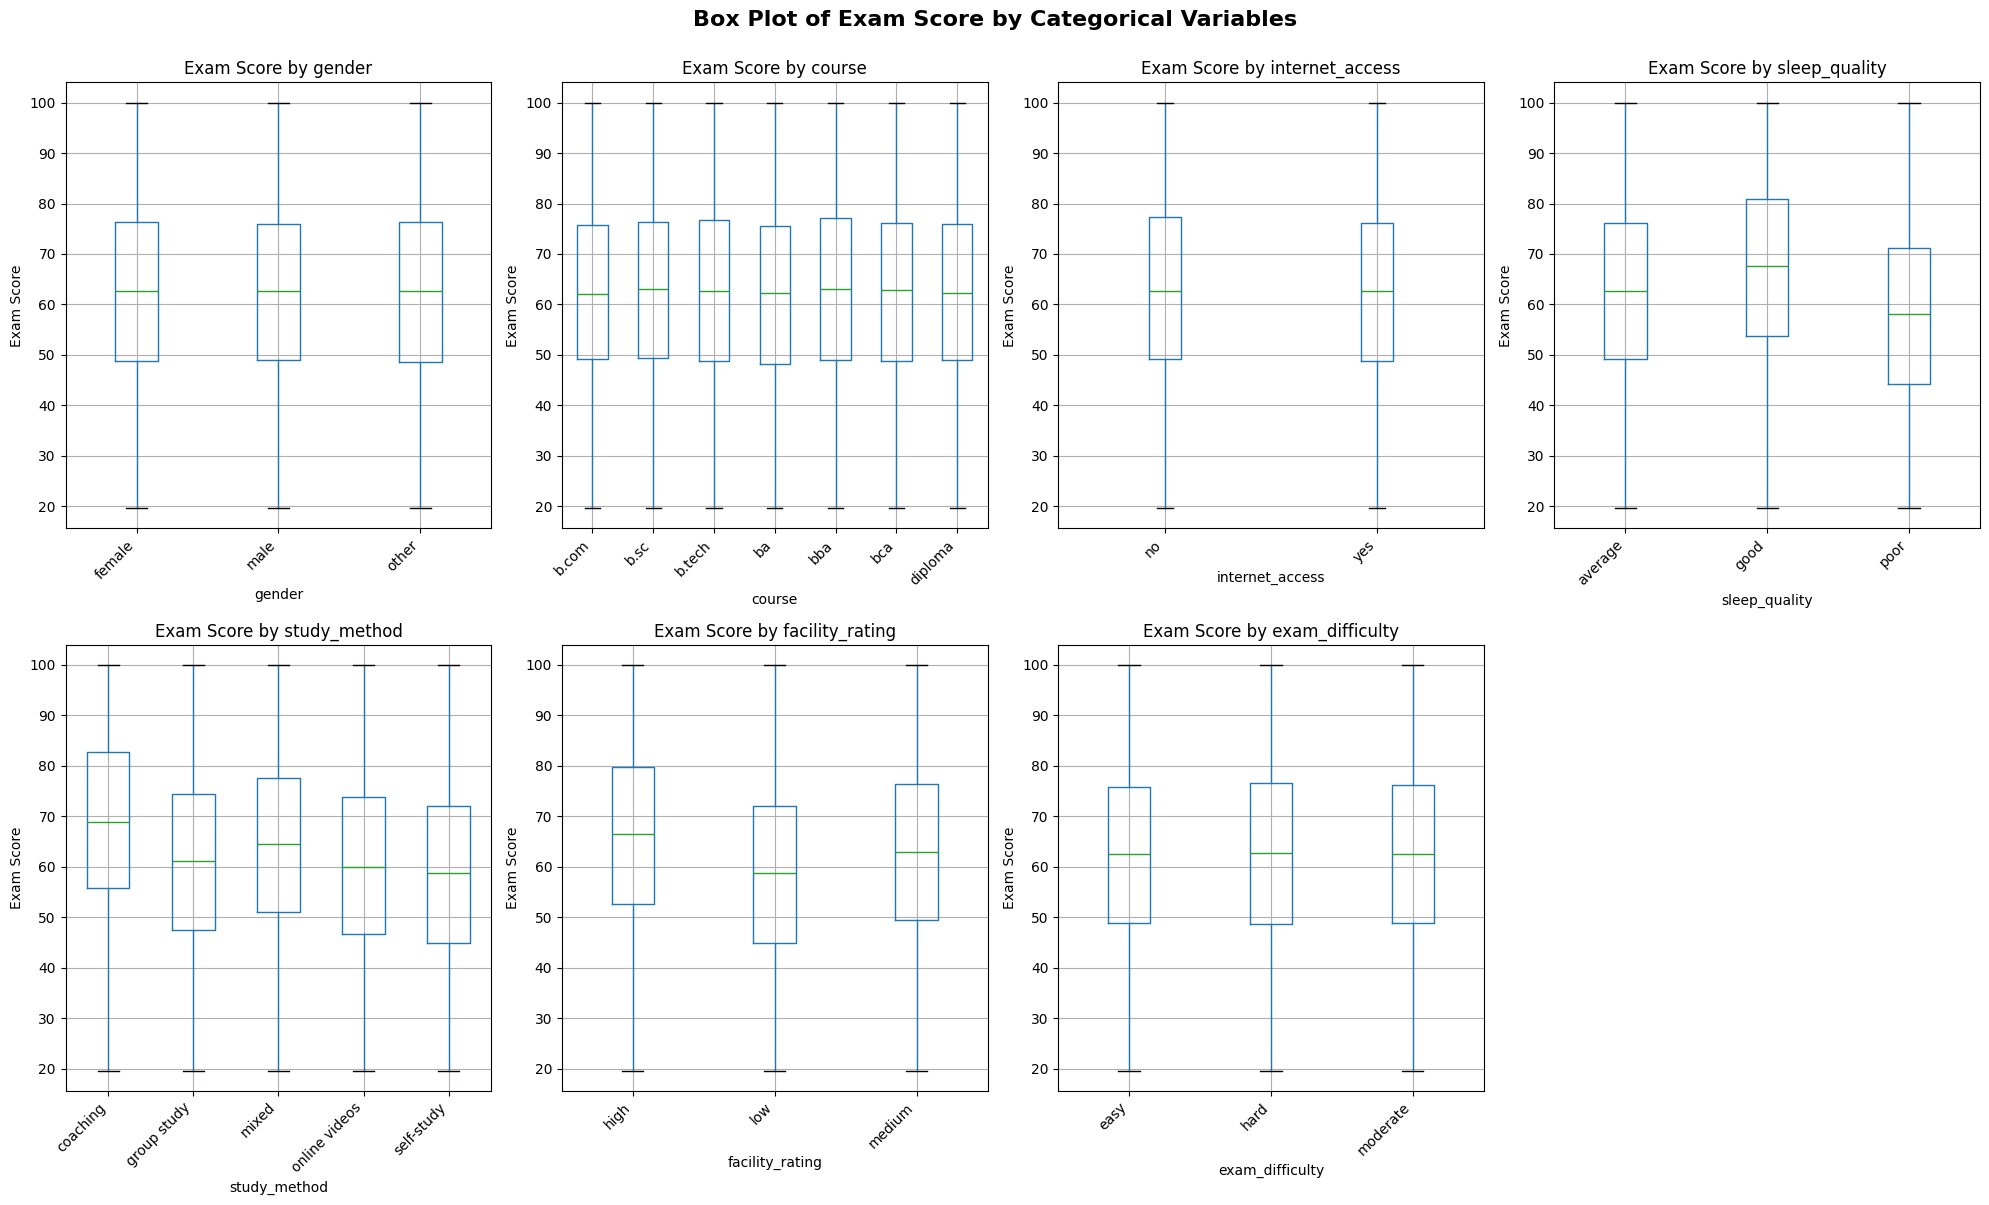

In [179]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    df.boxplot(column='exam_score', by=col, ax=axes[i])
    axes[i].set_title(f'Exam Score by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Exam Score')
    plt.sca(axes[i])
    plt.xticks(rotation=45, ha='right')

for j in range(len(categorical_cols), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Box Plot of Exam Score by Categorical Variables', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [180]:
# one-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# drop student id
df_encoded.drop('student_id', axis=1, inplace=True)

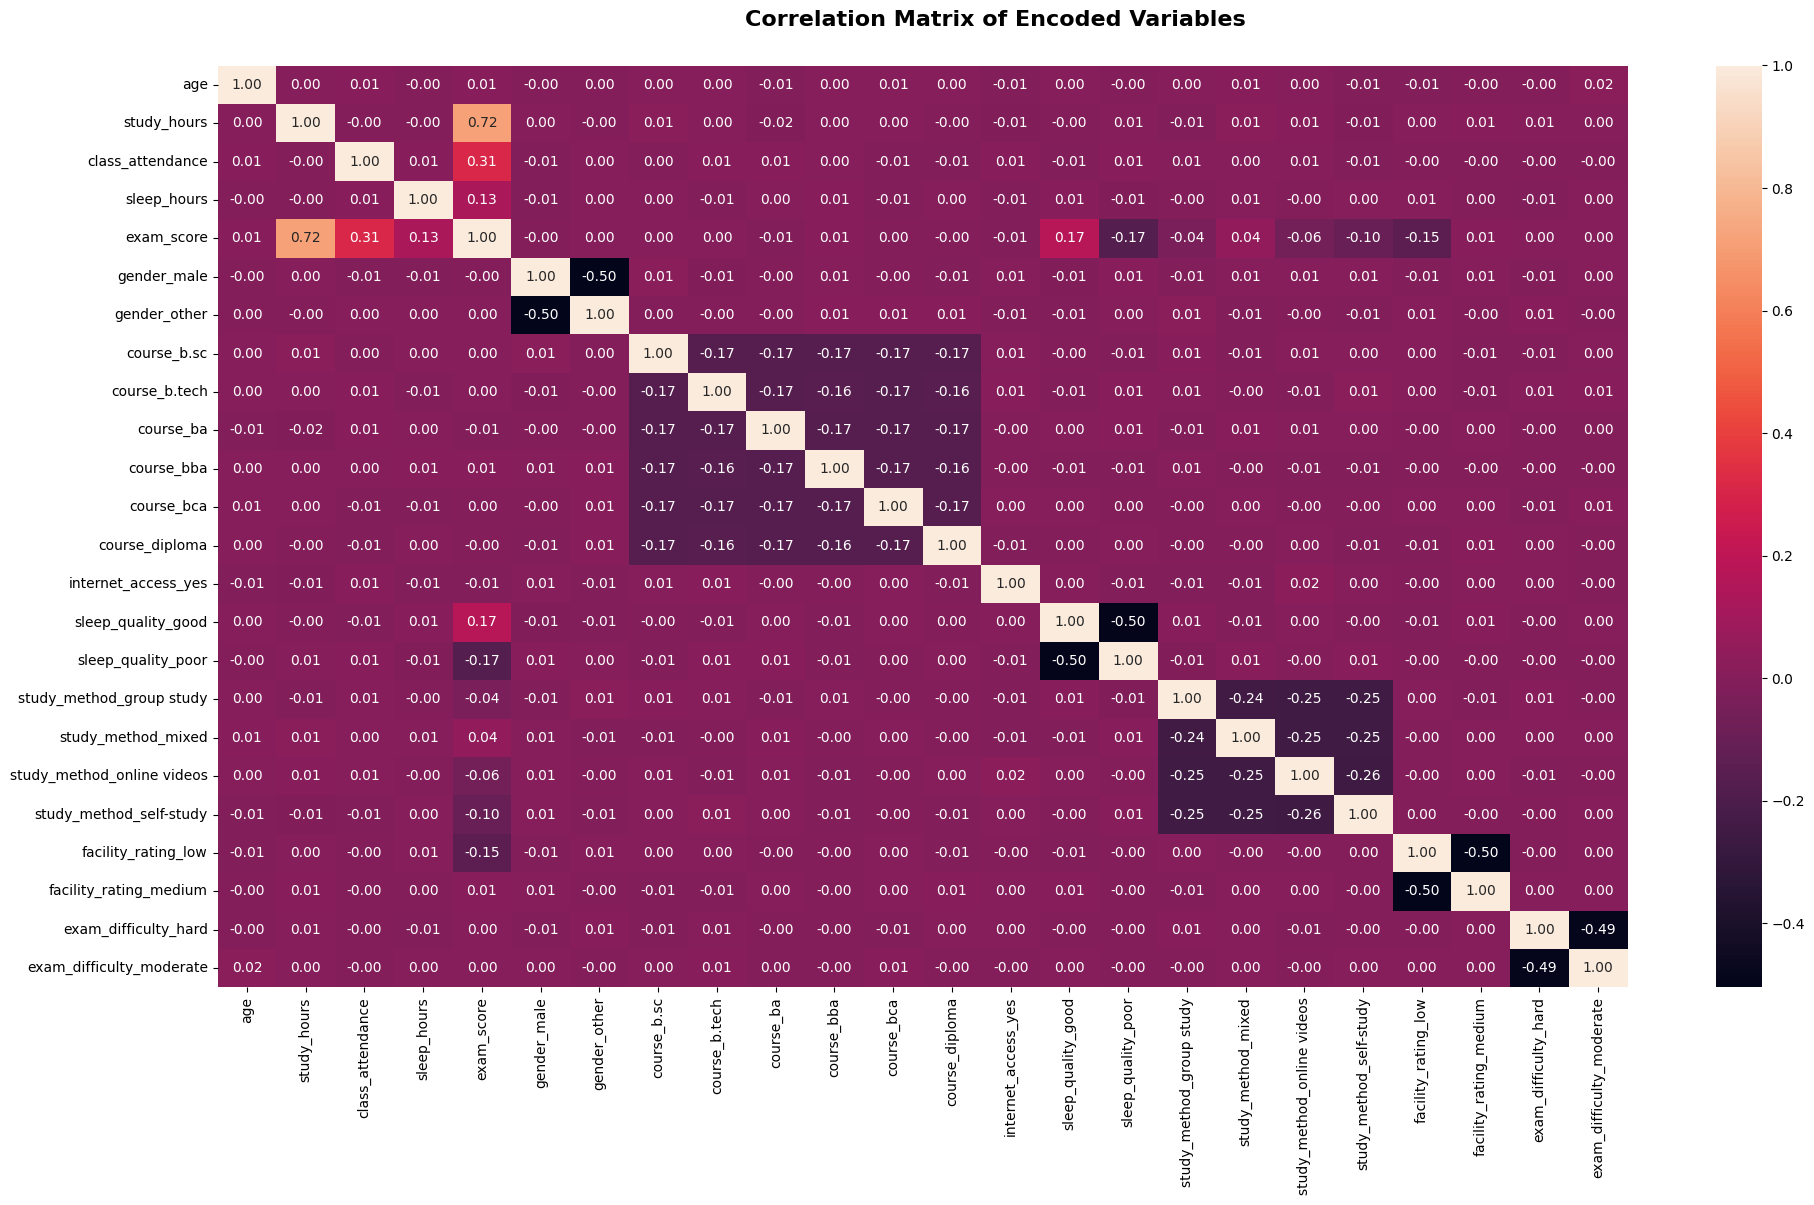

In [181]:
corr_matrix = df_encoded.corr()

plt.figure(figsize=(20,12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
)
plt.suptitle('Correlation Matrix of Encoded Variables', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [182]:
corr_with_score = df_encoded.corr()['exam_score'].sort_values(ascending=False)
corr_with_score = corr_with_score[corr_with_score.index != 'exam_score']

print("Top 5 Positive Correlations:")
print(corr_with_score.head(5))

print("\nBottom 5 Correlations:")
print(corr_with_score.tail(5))

Top 5 Positive Correlations:
study_hours           0.717788
class_attendance      0.308850
sleep_quality_good    0.172049
sleep_hours           0.133222
study_method_mixed    0.044980
Name: exam_score, dtype: float64

Bottom 5 Correlations:
study_method_group study     -0.040377
study_method_online videos   -0.063120
study_method_self-study      -0.101278
facility_rating_low          -0.146083
sleep_quality_poor           -0.172257
Name: exam_score, dtype: float64


In [183]:
print("\nTop 10 Absolute Correlations with Exam Score:")
print(corr_with_score.abs().sort_values(ascending=False).head(10))


Top 10 Absolute Correlations with Exam Score:
study_hours                   0.717788
class_attendance              0.308850
sleep_quality_poor            0.172257
sleep_quality_good            0.172049
facility_rating_low           0.146083
sleep_hours                   0.133222
study_method_self-study       0.101278
study_method_online videos    0.063120
study_method_mixed            0.044980
study_method_group study      0.040377
Name: exam_score, dtype: float64


## Feature Engineering Report

### Data Quality & Cleaning
- **No missing values** - All 20,000 records are complete across all variables
- **No outliers detected** - IQR method confirmed no extreme values in numeric features
- **No duplicates** - Student IDs are unique
- **Valid ranges** - Exam scores (0-100), sleep hours (realistic range), all within expected bounds

### Numeric Distribution Analysis
- **Numeric features** show relatively uniform/normal distributions

### Categorical Feature Analysis
- **7 categorical variables** identified: gender, course, internet access, sleep quantity, study method, facility rating, exam difficulty
- **Box plots reveal** clear performance differences between categories, suggesting categorical features are informative

### Feature Encoding
- **One-hot encoding** applied to all categorical variables
- **Drop first category** to avoid multicollinearity (dummy variable trap)
- **Student ID removed** - not predictive, only serves as identifier
- **Final feature set**: 4 numeric + encoded categorical features

### Correlation Insights

**Strong Positive Correlations (r > 0.30):**
- **study_hours** (r = 0.72): Strongest predictor - each additional study hour significantly boosts exam scores
- **class_attendance** (r = 0.31): Second strongest predictor - consistent attendance matters

**Moderate Positive Correlations (0.10 < r < 0.30):**
- **sleep_quality_good** (r = 0.17): Good sleep quality shows positive impact
- **sleep_hours** (r = 0.13): Adequate sleep duration contributes to performance

**Moderate Negative Correlations (-0.20 < r < -0.10):**
- **sleep_quality_poor** (r = -0.17): Poor sleep quality hurts performance
- **facility_rating_low** (r = -0.15): Low-quality facilities negatively impact scores
- **study_method_self-study** (r = -0.10): Self-study alone shows slight negative correlation

**Key Findings:**
- **Study hours dominate** - accounts for 72% correlation with exam scores
- **Behavioral factors matter** - attendance and sleep quality show consistent effects
- **Study methods vary** - mixed/group methods slightly better than self-study or videos alone
- **Environment matters** - poor facilities and sleep quality negatively impact performance
- **No strong multicollinearity** - top predictors are relatively independent

## Model Implementation

In [184]:
features = df_encoded.drop('exam_score', axis=1)
target = df_encoded['exam_score']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE
)

scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Lasso': Lasso(alpha=0.1, random_state=RANDOM_STATE, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=10000),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
}

results = []

for model_name, model in models.items():
    if model_name == 'Random Forest':
        model.fit(features_train, target_train)
        predictions = model.predict(features_test)
    else:
        model.fit(features_train_scaled, target_train)
        predictions = np.clip(model.predict(features_test_scaled), 0, 100)
    
    r2 = r2_score(target_test, predictions)
    rmse = np.sqrt(mean_squared_error(target_test, predictions))
    mae = mean_absolute_error(target_test, predictions)
    
    results.append({
        'Model': model_name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'R² Target': '✓ PASS' if r2 >= 0.7 else '✗ FAIL',
        'RMSE Target': '✓ PASS' if rmse <= 10 else '✗ FAIL'
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R²', ascending=False).reset_index(drop=True)

print(results_df.to_string(index=False))

best_model_idx = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_r2 = results_df.loc[best_model_idx, 'R²']
best_rmse = results_df.loc[best_model_idx, 'RMSE']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   R²:   {best_r2:.4f}")
print(f"   RMSE: {best_rmse:.4f}")

passing_models = results_df[(results_df['R²'] >= 0.7) & (results_df['RMSE'] <= 10)]
print(f"\n✅ Models meeting both targets (R² >= 0.7, RMSE <= 10): {len(passing_models)}")
if len(passing_models) > 0:
    print(passing_models[['Model', 'R²', 'RMSE']].to_string(index=False))

            Model       R²      RMSE      MAE R² Target RMSE Target
            Ridge 0.728905  9.722083 7.751173    ✓ PASS      ✓ PASS
Linear Regression 0.728903  9.722104 7.751159    ✓ PASS      ✓ PASS
            Lasso 0.728428  9.730623 7.769610    ✓ PASS      ✓ PASS
       ElasticNet 0.726438  9.766219 7.814388    ✓ PASS      ✓ PASS
    Random Forest 0.684400 10.489790 8.389911    ✗ FAIL      ✗ FAIL

🏆 Best Model: Ridge
   R²:   0.7289
   RMSE: 9.7221

✅ Models meeting both targets (R² >= 0.7, RMSE <= 10): 4
            Model       R²     RMSE
            Ridge 0.728905 9.722083
Linear Regression 0.728903 9.722104
            Lasso 0.728428 9.730623
       ElasticNet 0.726438 9.766219


In [185]:
top_10_features = corr_with_score.abs().sort_values(ascending=False).head(10).index.tolist()

features_all = df_encoded.drop('exam_score', axis=1)
features_top10 = df_encoded[top_10_features]
target = df_encoded['exam_score']

features_all_train, features_all_test, target_train, target_test = train_test_split(
    features_all, target, test_size=0.2, random_state=RANDOM_STATE
)

features_top10_train, features_top10_test, _, _ = train_test_split(
    features_top10, target, test_size=0.2, random_state=RANDOM_STATE
)

scaler_all = StandardScaler()
features_all_train_scaled = scaler_all.fit_transform(features_all_train)
features_all_test_scaled = scaler_all.transform(features_all_test)

scaler_top10 = StandardScaler()
features_top10_train_scaled = scaler_top10.fit_transform(features_top10_train)
features_top10_test_scaled = scaler_top10.transform(features_top10_test)

comparison_results = []

for model_name, model_class in [('Linear Regression', LinearRegression), ('Ridge', Ridge)]:
    model_all = model_class() if model_name == 'Linear Regression' else model_class(alpha=1.0, random_state=RANDOM_STATE)
    model_all.fit(features_all_train_scaled, target_train)
    predictions_all = np.clip(model_all.predict(features_all_test_scaled), 0, 100)
    
    r2_all = r2_score(target_test, predictions_all)
    rmse_all = np.sqrt(mean_squared_error(target_test, predictions_all))
    mae_all = mean_absolute_error(target_test, predictions_all)
    
    comparison_results.append({
        'Model': f'{model_name} (All Features)',
        'Features': len(features_all.columns),
        'R²': r2_all,
        'RMSE': rmse_all,
        'MAE': mae_all,
        'R² Target': '✓ PASS' if r2_all >= 0.7 else '✗ FAIL',
        'RMSE Target': '✓ PASS' if rmse_all <= 10 else '✗ FAIL'
    })
    
    model_top10 = model_class() if model_name == 'Linear Regression' else model_class(alpha=1.0, random_state=RANDOM_STATE)
    model_top10.fit(features_top10_train_scaled, target_train)
    predictions_top10 = np.clip(model_top10.predict(features_top10_test_scaled), 0, 100)
    
    r2_top10 = r2_score(target_test, predictions_top10)
    rmse_top10 = np.sqrt(mean_squared_error(target_test, predictions_top10))
    mae_top10 = mean_absolute_error(target_test, predictions_top10)
    
    comparison_results.append({
        'Model': f'{model_name} (Top 10 Features)',
        'Features': len(features_top10.columns),
        'R²': r2_top10,
        'RMSE': rmse_top10,
        'MAE': mae_top10,
        'R² Target': '✓ PASS' if r2_top10 >= 0.7 else '✗ FAIL',
        'RMSE Target': '✓ PASS' if rmse_top10 <= 10 else '✗ FAIL'
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nFeature Selection Comparison:")
print(comparison_df.to_string(index=False))

print("\n📊 Summary:")
for model_type in ['Linear Regression', 'Ridge']:
    all_feat = comparison_df[comparison_df['Model'] == f'{model_type} (All Features)'].iloc[0]
    top10_feat = comparison_df[comparison_df['Model'] == f'{model_type} (Top 10 Features)'].iloc[0]
    
    r2_diff = top10_feat['R²'] - all_feat['R²']
    rmse_diff = top10_feat['RMSE'] - all_feat['RMSE']
    
    print(f"\n{model_type}:")
    print(f"  R² change:   {r2_diff:+.4f} ({'improvement' if r2_diff > 0 else 'decline'})")
    print(f"  RMSE change: {rmse_diff:+.4f} ({'worse' if rmse_diff > 0 else 'better'})")


Feature Selection Comparison:
                              Model  Features       R²     RMSE      MAE R² Target RMSE Target
   Linear Regression (All Features)        23 0.728903 9.722104 7.751159    ✓ PASS      ✓ PASS
Linear Regression (Top 10 Features)        10 0.722730 9.832182 7.839388    ✓ PASS      ✓ PASS
               Ridge (All Features)        23 0.728905 9.722083 7.751173    ✓ PASS      ✓ PASS
            Ridge (Top 10 Features)        10 0.722731 9.832165 7.839399    ✓ PASS      ✓ PASS

📊 Summary:

Linear Regression:
  R² change:   -0.0062 (decline)
  RMSE change: +0.1101 (worse)

Ridge:
  R² change:   -0.0062 (decline)
  RMSE change: +0.1101 (worse)


In [186]:
features_all = df_encoded.drop('exam_score', axis=1)
target = df_encoded['exam_score']

features_all_train, features_all_test, target_train, target_test = train_test_split(
    features_all, target, test_size=0.2, random_state=RANDOM_STATE
)

scaler_all = StandardScaler()
features_all_train_scaled = scaler_all.fit_transform(features_all_train)
features_all_test_scaled = scaler_all.transform(features_all_test)

rfe_comparison_results = []

for model_name, model_class in [('Linear Regression', LinearRegression), ('Ridge', Ridge)]:
    # All Features
    model_all = model_class() if model_name == 'Linear Regression' else model_class(alpha=1.0, random_state=RANDOM_STATE)
    model_all.fit(features_all_train_scaled, target_train)
    predictions_all = np.clip(model_all.predict(features_all_test_scaled), 0, 100)
    
    r2_all = r2_score(target_test, predictions_all)
    rmse_all = np.sqrt(mean_squared_error(target_test, predictions_all))
    mae_all = mean_absolute_error(target_test, predictions_all)
    
    rfe_comparison_results.append({
        'Model': f'{model_name} (All Features)',
        'Features': len(features_all.columns),
        'R²': r2_all,
        'RMSE': rmse_all,
        'MAE': mae_all,
        'R² Target': '✓ PASS' if r2_all >= 0.7 else '✗ FAIL',
        'RMSE Target': '✓ PASS' if rmse_all <= 10 else '✗ FAIL'
    })
    
    # RFE Top 10
    base_model_10 = model_class() if model_name == 'Linear Regression' else model_class(alpha=1.0, random_state=RANDOM_STATE)
    rfe_10 = RFE(estimator=base_model_10, n_features_to_select=10)
    rfe_10.fit(features_all_train_scaled, target_train)
    
    features_rfe_10_train = rfe_10.transform(features_all_train_scaled)
    features_rfe_10_test = rfe_10.transform(features_all_test_scaled)
    
    selected_features_10 = features_all.columns[rfe_10.support_].tolist()
    
    model_rfe_10 = model_class() if model_name == 'Linear Regression' else model_class(alpha=1.0, random_state=RANDOM_STATE)
    model_rfe_10.fit(features_rfe_10_train, target_train)
    predictions_rfe_10 = np.clip(model_rfe_10.predict(features_rfe_10_test), 0, 100)
    
    r2_rfe_10 = r2_score(target_test, predictions_rfe_10)
    rmse_rfe_10 = np.sqrt(mean_squared_error(target_test, predictions_rfe_10))
    mae_rfe_10 = mean_absolute_error(target_test, predictions_rfe_10)
    
    rfe_comparison_results.append({
        'Model': f'{model_name} (RFE Top 10)',
        'Features': 10,
        'R²': r2_rfe_10,
        'RMSE': rmse_rfe_10,
        'MAE': mae_rfe_10,
        'R² Target': '✓ PASS' if r2_rfe_10 >= 0.7 else '✗ FAIL',
        'RMSE Target': '✓ PASS' if rmse_rfe_10 <= 10 else '✗ FAIL'
    })
    
    print(f"\n{model_name} - RFE Top 10 Selected Features:")
    for i, feat in enumerate(selected_features_10, 1):
        print(f"  {i}. {feat}")
    
    # RFE Top 5
    base_model_5 = model_class() if model_name == 'Linear Regression' else model_class(alpha=1.0, random_state=RANDOM_STATE)
    rfe_5 = RFE(estimator=base_model_5, n_features_to_select=5)
    rfe_5.fit(features_all_train_scaled, target_train)
    
    features_rfe_5_train = rfe_5.transform(features_all_train_scaled)
    features_rfe_5_test = rfe_5.transform(features_all_test_scaled)
    
    selected_features_5 = features_all.columns[rfe_5.support_].tolist()
    
    model_rfe_5 = model_class() if model_name == 'Linear Regression' else model_class(alpha=1.0, random_state=RANDOM_STATE)
    model_rfe_5.fit(features_rfe_5_train, target_train)
    predictions_rfe_5 = np.clip(model_rfe_5.predict(features_rfe_5_test), 0, 100)
    
    r2_rfe_5 = r2_score(target_test, predictions_rfe_5)
    rmse_rfe_5 = np.sqrt(mean_squared_error(target_test, predictions_rfe_5))
    mae_rfe_5 = mean_absolute_error(target_test, predictions_rfe_5)
    
    rfe_comparison_results.append({
        'Model': f'{model_name} (RFE Top 5)',
        'Features': 5,
        'R²': r2_rfe_5,
        'RMSE': rmse_rfe_5,
        'MAE': mae_rfe_5,
        'R² Target': '✓ PASS' if r2_rfe_5 >= 0.7 else '✗ FAIL',
        'RMSE Target': '✓ PASS' if rmse_rfe_5 <= 10 else '✗ FAIL'
    })
    
    print(f"\n{model_name} - RFE Top 5 Selected Features:")
    for i, feat in enumerate(selected_features_5, 1):
        print(f"  {i}. {feat}")


Linear Regression - RFE Top 10 Selected Features:
  1. study_hours
  2. class_attendance
  3. sleep_hours
  4. sleep_quality_good
  5. sleep_quality_poor
  6. study_method_group study
  7. study_method_mixed
  8. study_method_online videos
  9. study_method_self-study
  10. facility_rating_low

Linear Regression - RFE Top 5 Selected Features:
  1. study_hours
  2. class_attendance
  3. sleep_hours
  4. sleep_quality_poor
  5. facility_rating_low

Ridge - RFE Top 10 Selected Features:
  1. study_hours
  2. class_attendance
  3. sleep_hours
  4. sleep_quality_good
  5. sleep_quality_poor
  6. study_method_group study
  7. study_method_mixed
  8. study_method_online videos
  9. study_method_self-study
  10. facility_rating_low

Ridge - RFE Top 5 Selected Features:
  1. study_hours
  2. class_attendance
  3. sleep_hours
  4. sleep_quality_poor
  5. facility_rating_low


In [187]:
rfe_comparison_df = pd.DataFrame(rfe_comparison_results)
print("\nRFE Feature Selection Comparison:")
print(rfe_comparison_df.to_string(index=False))

print("\n📊 Summary:")
for model_type in ['Linear Regression', 'Ridge']:
    all_feat = rfe_comparison_df[rfe_comparison_df['Model'] == f'{model_type} (All Features)'].iloc[0]
    rfe_10_feat = rfe_comparison_df[rfe_comparison_df['Model'] == f'{model_type} (RFE Top 10)'].iloc[0]
    rfe_5_feat = rfe_comparison_df[rfe_comparison_df['Model'] == f'{model_type} (RFE Top 5)'].iloc[0]
    
    r2_diff_10 = rfe_10_feat['R²'] - all_feat['R²']
    rmse_diff_10 = rfe_10_feat['RMSE'] - all_feat['RMSE']
    
    r2_diff_5 = rfe_5_feat['R²'] - all_feat['R²']
    rmse_diff_5 = rfe_5_feat['RMSE'] - all_feat['RMSE']
    
    print(f"\n{model_type}:")
    print(f"  RFE Top 10:")
    print(f"    R² change:   {r2_diff_10:+.4f} ({'improvement' if r2_diff_10 > 0 else 'decline'})")
    print(f"    RMSE change: {rmse_diff_10:+.4f} ({'worse' if rmse_diff_10 > 0 else 'better'})")
    print(f"  RFE Top 5:")
    print(f"    R² change:   {r2_diff_5:+.4f} ({'improvement' if r2_diff_5 > 0 else 'decline'})")
    print(f"    RMSE change: {rmse_diff_5:+.4f} ({'worse' if rmse_diff_5 > 0 else 'better'})")


RFE Feature Selection Comparison:
                           Model  Features       R²      RMSE      MAE R² Target RMSE Target
Linear Regression (All Features)        23 0.728903  9.722104 7.751159    ✓ PASS      ✓ PASS
  Linear Regression (RFE Top 10)        10 0.722730  9.832182 7.839388    ✓ PASS      ✓ PASS
   Linear Regression (RFE Top 5)         5 0.676485 10.620505 8.488884    ✗ FAIL      ✗ FAIL
            Ridge (All Features)        23 0.728905  9.722083 7.751173    ✓ PASS      ✓ PASS
              Ridge (RFE Top 10)        10 0.722731  9.832165 7.839399    ✓ PASS      ✓ PASS
               Ridge (RFE Top 5)         5 0.676487 10.620484 8.488899    ✗ FAIL      ✗ FAIL

📊 Summary:

Linear Regression:
  RFE Top 10:
    R² change:   -0.0062 (decline)
    RMSE change: +0.1101 (worse)
  RFE Top 5:
    R² change:   -0.0524 (decline)
    RMSE change: +0.8984 (worse)

Ridge:
  RFE Top 10:
    R² change:   -0.0062 (decline)
    RMSE change: +0.1101 (worse)
  RFE Top 5:
    R² change:  

In [188]:
from sklearn.model_selection import GridSearchCV

features = df_encoded.drop('exam_score', axis=1)
target = df_encoded['exam_score']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE
)

scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

ridge_baseline = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_baseline.fit(features_train_scaled, target_train)
ridge_pred_baseline = np.clip(ridge_baseline.predict(features_test_scaled), 0, 100)

r2_baseline = r2_score(target_test, ridge_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(target_test, ridge_pred_baseline))
mae_baseline = mean_absolute_error(target_test, ridge_pred_baseline)

ridge_params = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0, 1000.0]
}

ridge_search = GridSearchCV(
    Ridge(random_state=RANDOM_STATE),
    ridge_params,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

ridge_search.fit(features_train_scaled, target_train)
ridge_pred_tuned = np.clip(ridge_search.predict(features_test_scaled), 0, 100)

r2_tuned = r2_score(target_test, ridge_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(target_test, ridge_pred_tuned))
mae_tuned = mean_absolute_error(target_test, ridge_pred_tuned)

comparison_data = [
    {
        'Model': 'Ridge (Baseline)',
        'Alpha': 1.0,
        'R²': r2_baseline,
        'RMSE': rmse_baseline,
        'MAE': mae_baseline,
        'R² Target': '✓ PASS' if r2_baseline >= 0.7 else '✗ FAIL',
        'RMSE Target': '✓ PASS' if rmse_baseline <= 10 else '✗ FAIL'
    },
    {
        'Model': 'Ridge (Tuned)',
        'Alpha': ridge_search.best_params_['alpha'],
        'R²': r2_tuned,
        'RMSE': rmse_tuned,
        'MAE': mae_tuned,
        'R² Target': '✓ PASS' if r2_tuned >= 0.7 else '✗ FAIL',
        'RMSE Target': '✓ PASS' if rmse_tuned <= 10 else '✗ FAIL'
    }
]

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

r2_improvement = r2_tuned - r2_baseline
rmse_improvement = rmse_baseline - rmse_tuned
mae_improvement = mae_baseline - mae_tuned

print(f"\nBest Alpha Found: {ridge_search.best_params_['alpha']}")
print(f"\nR² Improvement:   {r2_improvement:+.6f} ({(r2_improvement/r2_baseline)*100:+.3f}%)")
print(f"RMSE Improvement: {rmse_improvement:+.6f} ({(rmse_improvement/rmse_baseline)*100:+.3f}%)")
print(f"MAE Improvement:  {mae_improvement:+.6f} ({(mae_improvement/mae_baseline)*100:+.3f}%)")

print("\n" + "="*80)
if r2_tuned > r2_baseline and rmse_tuned < rmse_baseline:
    print("✅ WINNER: Ridge (Tuned)")
    print(f"   R²:   {r2_tuned:.6f}")
    print(f"   RMSE: {rmse_tuned:.6f}")
    print(f"   MAE:  {mae_tuned:.6f}")
elif r2_baseline > r2_tuned and rmse_baseline < rmse_tuned:
    print("✅ WINNER: Ridge (Baseline)")
    print(f"   R²:   {r2_baseline:.6f}")
    print(f"   RMSE: {rmse_baseline:.6f}")
    print(f"   MAE:  {mae_baseline:.6f}")
else:
    if abs(r2_tuned - r2_baseline) < 0.0001:
        print("⚖️  RESULT: Nearly Identical Performance")
        print("   Difference is negligible (< 0.0001)")
        print("   ➡️  Recommendation: Use Baseline (simpler, alpha=1.0)")
    else:
        print("⚖️  RESULT: Mixed Performance")
        print(f"   Better R²:   {'Tuned' if r2_tuned > r2_baseline else 'Baseline'}")
        print(f"   Better RMSE: {'Tuned' if rmse_tuned < rmse_baseline else 'Baseline'}")
print("="*80)

           Model  Alpha       R²     RMSE      MAE R² Target RMSE Target
Ridge (Baseline)    1.0 0.728905 9.722083 7.751173    ✓ PASS      ✓ PASS
   Ridge (Tuned)   10.0 0.728915 9.721901 7.751335    ✓ PASS      ✓ PASS

Best Alpha Found: 10.0

R² Improvement:   +0.000010 (+0.001%)
RMSE Improvement: +0.000181 (+0.002%)
MAE Improvement:  -0.000162 (-0.002%)

✅ WINNER: Ridge (Tuned)
   R²:   0.728915
   RMSE: 9.721901
   MAE:  7.751335


In [189]:
joblib.dump(ridge_search.best_estimator_, 'ridge_tuned_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print(f"\nModel saved as: ridge_tuned_model.pkl")
print(f"Scaler saved as: scaler.pkl")
print(f"\nBest Parameters:")
print(f"  Alpha: {ridge_search.best_params_['alpha']}")
print(f"\nModel Performance:")
print(f"  R²:   {r2_tuned:.4f}")
print(f"  RMSE: {rmse_tuned:.4f}")
print(f"  MAE:  {mae_tuned:.4f}")
print("\n" + "="*80)


Model saved as: ridge_tuned_model.pkl
Scaler saved as: scaler.pkl

Best Parameters:
  Alpha: 10.0

Model Performance:
  R²:   0.7289
  RMSE: 9.7219
  MAE:  7.7513



In [195]:
ridge_model_tuned = ridge_search.best_estimator_

# Extract Ridge model coefficients
ridge_coefficients = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': ridge_model_tuned.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n" + "="*80)
print("RIDGE REGRESSION COEFFICIENTS - ALL FEATURES")
print("="*80)
print(f"\nModel: Ridge Regression (Alpha = {ridge_search.best_params_['alpha']})")
print(f"Intercept: {ridge_model_tuned.intercept_:.4f}")
print("\nAll Features Sorted by Absolute Coefficient Value:")
print(ridge_coefficients.to_string(index=False))

# Summary statistics
print("\n" + "="*80)
print("COEFFICIENT SUMMARY STATISTICS")
print("="*80)
print(f"\nTotal Features: {len(ridge_coefficients)}")
print(f"Positive Coefficients: {len(ridge_coefficients[ridge_coefficients['Coefficient'] > 0])}")
print(f"Negative Coefficients: {len(ridge_coefficients[ridge_coefficients['Coefficient'] < 0])}")
print(f"\nLargest Positive Coefficient: {ridge_coefficients['Coefficient'].max():.4f} ({ridge_coefficients.loc[ridge_coefficients['Coefficient'].idxmax(), 'Feature']})")
print(f"Largest Negative Coefficient: {ridge_coefficients['Coefficient'].min():.4f} ({ridge_coefficients.loc[ridge_coefficients['Coefficient'].idxmin(), 'Feature']})")
print(f"Mean Absolute Coefficient: {ridge_coefficients['Coefficient'].abs().mean():.4f}")
print(f"Median Absolute Coefficient: {ridge_coefficients['Coefficient'].abs().median():.4f}")

# Top 10 by absolute value
print("\n" + "="*80)
print("TOP 10 MOST IMPACTFUL FEATURES (By Absolute Coefficient)")
print("="*80)
print(ridge_coefficients.head(10).to_string(index=False))


RIDGE REGRESSION COEFFICIENTS - ALL FEATURES

Model: Ridge Regression (Alpha = 10.0)
Intercept: 62.4550

All Features Sorted by Absolute Coefficient Value:
                   Feature  Coefficient
               study_hours    13.645829
          class_attendance     5.943364
   study_method_self-study    -3.776555
       facility_rating_low    -3.680050
study_method_online videos    -3.580079
  study_method_group study    -3.087622
               sleep_hours     2.467242
        sleep_quality_poor    -2.289555
        sleep_quality_good     2.141990
        study_method_mixed    -1.921513
    facility_rating_medium    -1.795114
              gender_other     0.089881
                 course_ba     0.064645
             course_b.tech     0.050988
                course_bba     0.048787
               course_b.sc    -0.038000
                course_bca     0.031926
      exam_difficulty_hard     0.030303
               gender_male     0.029371
  exam_difficulty_moderate     0.023223
   

### Bias & Fairness Analysis

#### SHAP - Analysis


1. SHAP Feature Importance (All Features)
                   Feature  Mean |SHAP|
               study_hours    11.751869
          class_attendance     5.106994
       facility_rating_low     3.455381
study_method_online videos     2.922703
   study_method_self-study     2.776959
  study_method_group study     2.396610
        sleep_quality_poor     2.238471
               sleep_hours     2.152742
        sleep_quality_good     1.960646
    facility_rating_medium     1.703405
        study_method_mixed     1.487935
              gender_other     0.083001
                 course_ba     0.043449
             course_b.tech     0.038228
                course_bba     0.033427
               course_b.sc     0.030553
               gender_male     0.028933
      exam_difficulty_hard     0.023575
  exam_difficulty_moderate     0.023224
                course_bca     0.020719
       internet_access_yes     0.011870
                       age     0.008969
            course_diploma     0.0047

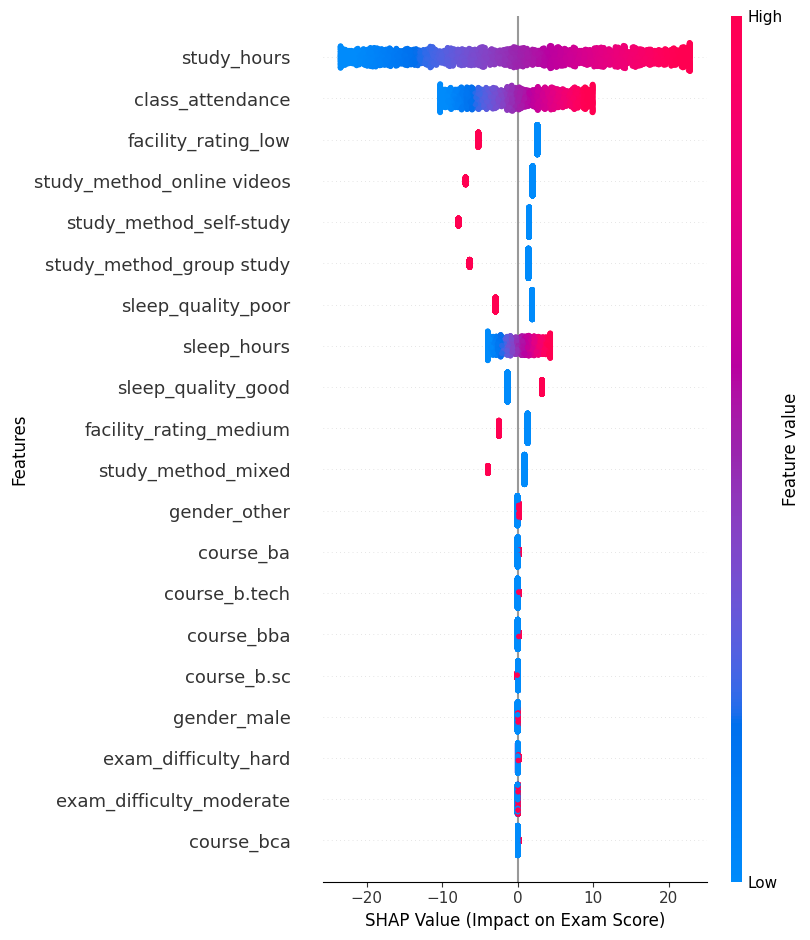

In [ ]:
# Use the already-fitted model and scaler from previous cell
ridge_model_tuned = ridge_search.best_estimator_

# Create SHAP explainer for linear model
explainer = shap.LinearExplainer(ridge_model_tuned, features_train_scaled, feature_names=features.columns)
shap_values = explainer.shap_values(features_test_scaled)

print("\n1. SHAP Feature Importance (All Features)")
print(shap_importance_df.to_string(index=False))

print("\n2. SHAP Summary Plot (Detailed Impact)")
fig, ax = plt.subplots(figsize=(12, 10))
shap.summary_plot(shap_values, features_test_scaled, feature_names=features.columns, show=False)
ax = plt.gca()
ax.set_xlabel('SHAP Value (Impact on Exam Score)', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
plt.show()

# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Mean |SHAP Value|': mean_abs_shap
}).sort_values('Mean |SHAP Value|', ascending=False)

In [191]:
# Explain individual predictions
print("\n3. Individual Prediction Explanations (First 3 Students)")
for i in range(3):
    print(f"Student {i+1}:")
    print(f"   Actual Score: {target_test.iloc[i]:.2f}")
    print(f"   Predicted Score: {ridge_pred_tuned[i]:.2f}")
    
    # Get SHAP values for this student
    student_shap = pd.DataFrame({
        'Feature': features.columns,
        'SHAP Value': shap_values[i]
    }).sort_values('SHAP Value', key=abs, ascending=False).head(5)
    
    print(f"   Top 5 Contributing Features:")
    for idx, row in student_shap.iterrows():
        impact = "increases" if row['SHAP Value'] > 0 else "decreases"
        print(f"     • {row['Feature']}: {impact} score by {abs(row['SHAP Value']):.2f} points")


3. Individual Prediction Explanations (First 3 Students)
Student 1:
   Actual Score: 58.10
   Predicted Score: 75.94
   Top 5 Contributing Features:
     • study_hours: increases score by 18.76 points
     • class_attendance: decreases score by 6.20 points
     • sleep_quality_poor: decreases score by 2.96 points
     • facility_rating_low: increases score by 2.58 points
     • facility_rating_medium: decreases score by 2.51 points
Student 2:
   Actual Score: 64.40
   Predicted Score: 57.86
   Top 5 Contributing Features:
     • study_hours: decreases score by 9.00 points
     • study_method_self-study: decreases score by 7.86 points
     • class_attendance: increases score by 4.44 points
     • sleep_quality_good: increases score by 3.18 points
     • facility_rating_low: increases score by 2.58 points
Student 3:
   Actual Score: 46.60
   Predicted Score: 34.62
   Top 5 Contributing Features:
     • study_hours: decreases score by 22.47 points
     • study_method_online videos: decre

In [192]:
from lime import lime_tabular

lime_explainer = lime_tabular.LimeTabularExplainer(
    features_train_scaled,
    feature_names=features.columns.tolist(),
    mode='regression',
    random_state=RANDOM_STATE
)

lime_results = []

for i in range(3):
    explanation = lime_explainer.explain_instance(
        features_test_scaled[i],
        ridge_model_tuned.predict,
        num_features=10
    )
    
    actual = target_test.iloc[i]
    predicted = ridge_pred_tuned[i]
    
    lime_features = explanation.as_list()
    
    print(f"Student {i+1}:")
    print(f"   Actual Score: {target_test.iloc[i]:.2f}")
    print(f"   Predicted Score: {ridge_pred_tuned[i]:.2f}")
    
    student_lime = pd.DataFrame({
        'Feature Condition': [feat for feat, _ in lime_features[:5]],
        'LIME Weight': [weight for _, weight in lime_features[:5]]
    })
    student_lime['Abs Weight'] = student_lime['LIME Weight'].abs()
    student_lime = student_lime.sort_values('Abs Weight', ascending=False)
    
    print(f"   Top 5 Contributing Features:")
    for idx, row in student_lime.iterrows():
        impact = "increases" if row['LIME Weight'] > 0 else "decreases"
        print(f"     • {row['Feature Condition']}: {impact} score by {abs(row['LIME Weight']):.2f} points")
    
    for feat, weight in lime_features[:10]:
        lime_results.append({
            'Student': i+1,
            'Feature Condition': feat,
            'LIME Weight': weight
        })

Student 1:
   Actual Score: 58.10
   Predicted Score: 75.94
   Top 5 Contributing Features:
     • study_hours > 0.86: increases score by 23.48 points
     • class_attendance <= -0.87: decreases score by 10.64 points
     • study_method_self-study <= -0.51: increases score by 7.60 points
     • study_method_online videos <= -0.51: increases score by 7.11 points
     • study_method_group study <= -0.49: increases score by 6.85 points
Student 2:
   Actual Score: 64.40
   Predicted Score: 57.86
   Top 5 Contributing Features:
     • -0.87 < study_hours <= 0.01: decreases score by 7.64 points
     • study_method_online videos <= -0.51: increases score by 6.82 points
     • study_method_self-study > -0.51: decreases score by 6.74 points
     • study_method_group study <= -0.49: increases score by 6.51 points
     • facility_rating_low <= -0.71: increases score by 5.66 points
Student 3:
   Actual Score: 46.60
   Predicted Score: 34.62
   Top 5 Contributing Features:
     • study_hours <= -0.

In [193]:
print("\n" + "="*80)
print("LIME vs SHAP FEATURE IMPORTANCE COMPARISON")
print("="*80)

# SHAP Feature Importance (already calculated)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Mean |SHAP|': mean_abs_shap
}).sort_values('Mean |SHAP|', ascending=False)

# LIME Feature Importance - Extract feature names from conditions
all_lime_weights = []
for result in lime_results:
    feature_condition = result['Feature Condition']
    
    # Extract feature name from LIME condition
    base_feat = None
    
    # Try to match against actual feature names
    for actual_feature in features.columns:
        if actual_feature in feature_condition:
            base_feat = actual_feature
            break
    
    # Fallback: split and check each part
    if base_feat is None:
        parts = feature_condition.replace('<=', ' ').replace('>=', ' ').replace('<', ' ').replace('>', ' ').split()
        for part in parts:
            if part in features.columns:
                base_feat = part
                break
    
    # Last resort: use first non-numeric part
    if base_feat is None:
        for part in parts:
            try:
                float(part)
            except:
                base_feat = part
                break
    
    if base_feat is None:
        base_feat = feature_condition
    
    all_lime_weights.append({
        'Feature': base_feat,
        'Abs Weight': abs(result['LIME Weight'])
    })

lime_weights_df = pd.DataFrame(all_lime_weights)
lime_importance_df = lime_weights_df.groupby('Feature')['Abs Weight'].mean().reset_index()
lime_importance_df.columns = ['Feature', 'Mean |LIME|']
lime_importance_df = lime_importance_df.sort_values('Mean |LIME|', ascending=False)

print("\n📊 LIME Top 10 Features:")
print(lime_importance_df.head(10).to_string(index=False))

# Compare Top 10 from both methods
top_shap_features = set(shap_importance_df.head(10)['Feature'].tolist())
top_lime_features = set(lime_importance_df.head(10)['Feature'].tolist())

overlap = top_shap_features.intersection(top_lime_features)

print("\n" + "="*80)
print("INTERSECTION ANALYSIS")
print("="*80)
print(f"\n✅ Features in BOTH Top 10: {len(overlap)}")
if overlap:
    print(f"\n🎯 Common Top Features:")
    for feat in sorted(overlap):
        shap_val = shap_importance_df[shap_importance_df['Feature'] == feat]['Mean |SHAP|'].values[0]
        lime_val = lime_importance_df[lime_importance_df['Feature'] == feat]['Mean |LIME|'].values[0]
        print(f"   • {feat}")
        print(f"     - SHAP: {shap_val:.4f}")
        print(f"     - LIME: {lime_val:.4f}")

print(f"\n❌ SHAP Only (not in LIME top 10): {len(top_shap_features - top_lime_features)}")
if top_shap_features - top_lime_features:
    for feat in sorted(top_shap_features - top_lime_features):
        print(f"   • {feat}")

print(f"\n❌ LIME Only (not in SHAP top 10): {len(top_lime_features - top_shap_features)}")
if top_lime_features - top_shap_features:
    for feat in sorted(top_lime_features - top_shap_features):
        print(f"   • {feat}")

# Combined comparison table
comparison_df = shap_importance_df.head(10).merge(
    lime_importance_df, 
    on='Feature', 
    how='outer'
).fillna(0).sort_values('Mean |SHAP|', ascending=False)

print("\n" + "="*80)
print("COMBINED COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print(f"Agreement Rate: {len(overlap)}/10 = {(len(overlap)/10)*100:.1f}%")
print("="*80)


LIME vs SHAP FEATURE IMPORTANCE COMPARISON

📊 LIME Top 10 Features:
                   Feature  Mean |LIME|
               study_hours    18.256393
   study_method_self-study     7.304888
study_method_online videos     6.985439
  study_method_group study     6.571487
          class_attendance     5.863197
       facility_rating_low     5.396517
               sleep_hours     3.993542
        study_method_mixed     3.832491
        sleep_quality_poor     3.466520
    facility_rating_medium     2.929569

INTERSECTION ANALYSIS

✅ Features in BOTH Top 10: 9

🎯 Common Top Features:
   • class_attendance
     - SHAP: 5.1070
     - LIME: 5.8632
   • facility_rating_low
     - SHAP: 3.4554
     - LIME: 5.3965
   • facility_rating_medium
     - SHAP: 1.7034
     - LIME: 2.9296
   • sleep_hours
     - SHAP: 2.1527
     - LIME: 3.9935
   • sleep_quality_poor
     - SHAP: 2.2385
     - LIME: 3.4665
   • study_hours
     - SHAP: 11.7519
     - LIME: 18.2564
   • study_method_group study
     - SH

### Conclusion
The bias analysis, informed by both SHAP and LIME results, indicates that the model’s predictions are driven by non-sensitive, performance-related features. Across both methodologies, the most influential factors consistently relate to academic behavior and learning conditions, such as study hours, class attendance, study methods, sleep patterns, and facility quality. These variables are directly connected to educational engagement and outcomes rather than personal or sensitive characteristics.

Importantly, none of the dominant features correspond to inherently sensitive attributes (e.g., demographic or identity-related factors like gender). The absence of such features among the top contributors suggests that the model does not rely on proxies for sensitive issues when generating predictions. This reduces the likelihood of unintended bias arising from protected or socially sensitive characteristics.

Overall, the agreement between SHAP and LIME strengthens confidence that the model’s decision-making process is grounded in contextually appropriate and ethically acceptable inputs. As a result, no additional bias mitigation steps are required beyond standard validation, as the explanatory analyses already demonstrate that predictions are not influenced by sensitive or protected factors.